In [52]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


In [4]:

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:

# Define transformations for the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [24]:

# # Load MNIST dataset
# mnist = fetch_openml('mnist_784', version=1)
# X, y = mnist.data, mnist.target.astype(np.int32)


# # Train-test split: Keep original test size of 10,000 images
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, stratify=y, random_state=42)


In [6]:
# # Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


In [17]:

# # Use a smaller subset of the training set if compute is limited
train_data, _ = train_test_split(train_dataset, train_size=0.95, stratify=[label for _, label in train_dataset])

In [18]:
len(train_data)

57000

In [19]:
# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [20]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [21]:
# Instantiate the model, define loss and optimizer
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
# Training loop
def train(model, loader, criterion, optimizer):
    model.train()
    for epoch in range(100):  # Train for 5 epochs
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

In [35]:
# Train the MLP model
train(model, train_loader, criterion, optimizer)

Epoch [1/100], Loss: 0.1558
Epoch [2/100], Loss: 0.0510
Epoch [3/100], Loss: 0.2543
Epoch [4/100], Loss: 0.0593
Epoch [5/100], Loss: 0.0830
Epoch [6/100], Loss: 0.0215
Epoch [7/100], Loss: 0.1364
Epoch [8/100], Loss: 0.0360
Epoch [9/100], Loss: 0.0156
Epoch [10/100], Loss: 0.0088
Epoch [11/100], Loss: 0.0087
Epoch [12/100], Loss: 0.0239
Epoch [13/100], Loss: 0.0062
Epoch [14/100], Loss: 0.0004
Epoch [15/100], Loss: 0.0850
Epoch [16/100], Loss: 0.0210
Epoch [17/100], Loss: 0.0396
Epoch [18/100], Loss: 0.1053
Epoch [19/100], Loss: 0.0065
Epoch [20/100], Loss: 0.0053
Epoch [21/100], Loss: 0.0003
Epoch [22/100], Loss: 0.0018
Epoch [23/100], Loss: 0.0022
Epoch [24/100], Loss: 0.0003
Epoch [25/100], Loss: 0.0278
Epoch [26/100], Loss: 0.0545
Epoch [27/100], Loss: 0.0307
Epoch [28/100], Loss: 0.0071
Epoch [29/100], Loss: 0.0617
Epoch [30/100], Loss: 0.0226
Epoch [31/100], Loss: 0.0213
Epoch [32/100], Loss: 0.0180
Epoch [33/100], Loss: 0.0002
Epoch [34/100], Loss: 0.0156
Epoch [35/100], Loss: 0

In [36]:
# Evaluate the MLP on test data
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return all_preds, all_labels

In [37]:
mlp_preds, y_test = evaluate(model, test_loader)

In [38]:
# F1-Score for MLP
mlp_f1 = f1_score(y_test, mlp_preds, average='weighted')

# Confusion Matrix for MLP
mlp_cm = confusion_matrix(y_test, mlp_preds)

In [39]:
# Visualize Confusion Matrix
def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

In [41]:
# Train and Evaluate Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_train = train_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_f1 = f1_score(y_test, rf_preds, average='weighted')
rf_cm = confusion_matrix(y_test, rf_preds)

In [42]:

# Train and Evaluate Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict(X_test)
logreg_f1 = f1_score(y_test, logreg_preds, average='weighted')
logreg_cm = confusion_matrix(y_test, logreg_preds)

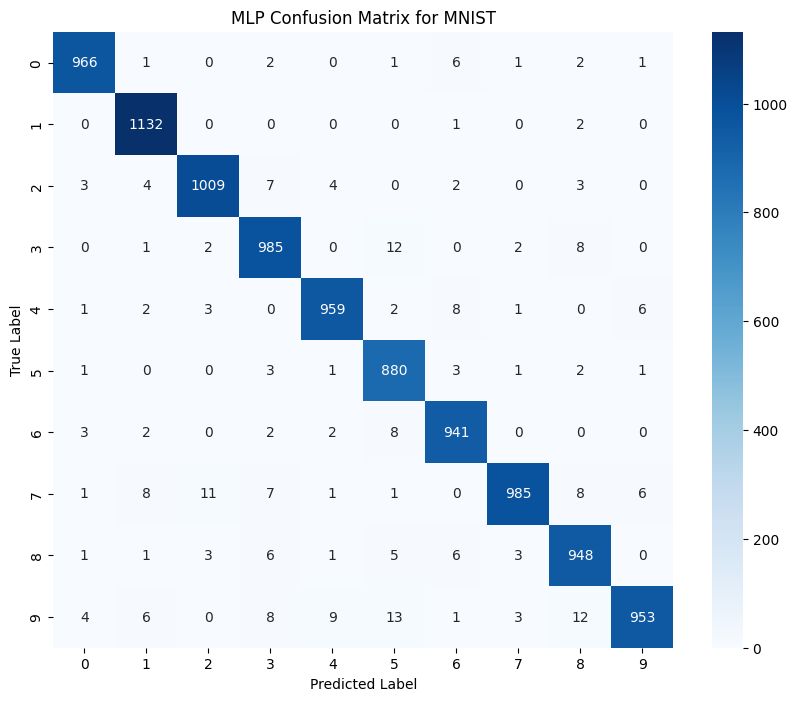

In [43]:
plot_confusion_matrix(mlp_cm, labels=[str(i) for i in range(10)], title="MLP Confusion Matrix for MNIST")

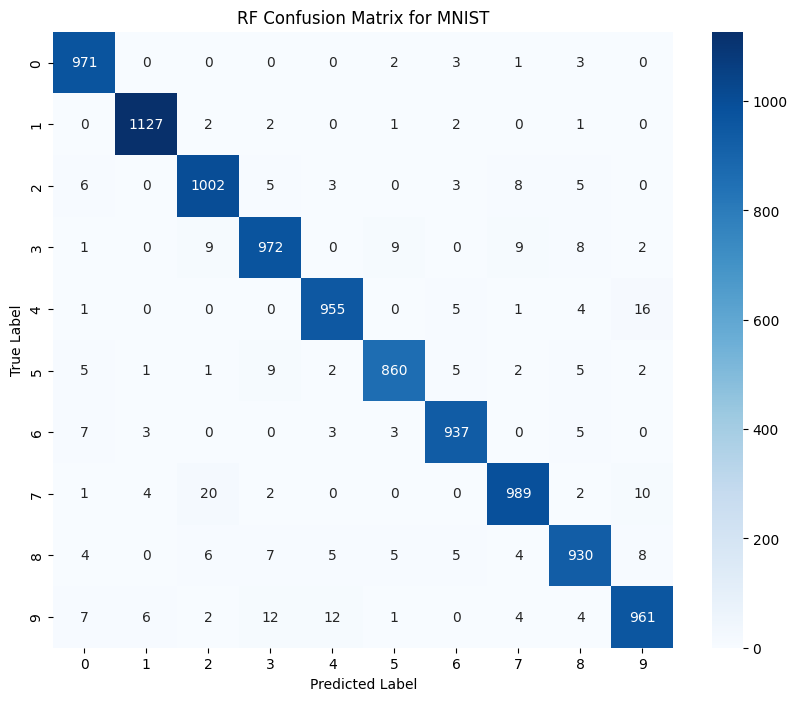

In [44]:
plot_confusion_matrix(rf_cm, labels=[str(i) for i in range(10)], title="RF Confusion Matrix for MNIST")

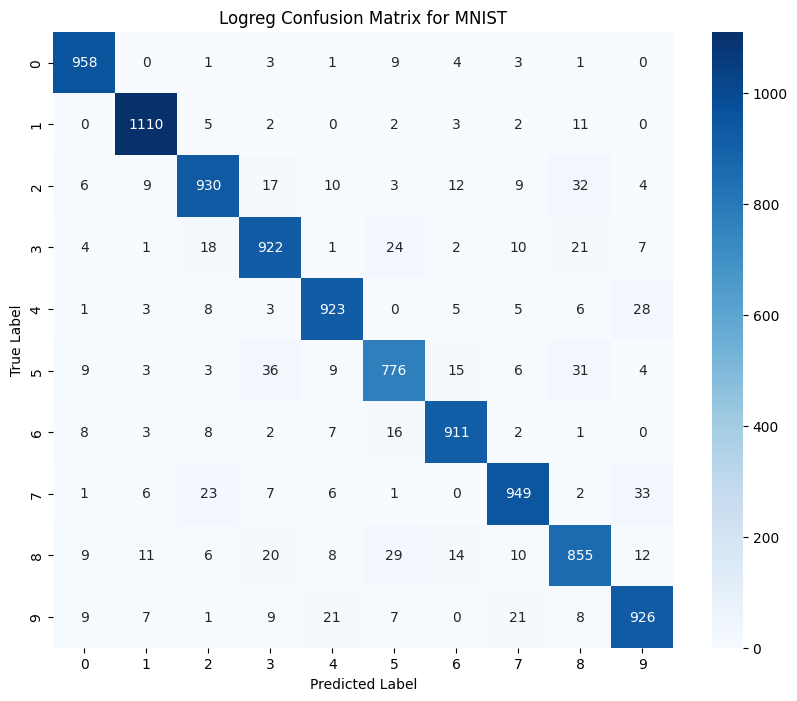

In [45]:
plot_confusion_matrix(logreg_cm, labels=[str(i) for i in range(10)], title="Logreg Confusion Matrix for MNIST")

In [46]:
# Compare F1-Scores
print(f"MLP F1-Score: {mlp_f1:.4f}")
print(f"Random Forest F1-Score: {rf_f1:.4f}")
print(f"Logistic Regression F1-Score: {logreg_f1:.4f}")

MLP F1-Score: 0.9758
Random Forest F1-Score: 0.9704
Logistic Regression F1-Score: 0.9258


In [47]:
# Observations from Confusion Matrix
print("MLP Confusion Matrix Report:")
print(classification_report(y_test, mlp_preds))

MLP Confusion Matrix Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.95      0.99      0.97       892
           6       0.97      0.98      0.98       958
           7       0.99      0.96      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.99      0.94      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [48]:
# Observations from Confusion Matrix
print("RF Confusion Matrix Report:")
print(classification_report(y_test, rf_preds))

RF Confusion Matrix Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [49]:
# Observations from Confusion Matrix
print("Logreg Confusion Matrix Report:")
print(classification_report(y_test, logreg_preds))

Logreg Confusion Matrix Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



In [50]:
# Initialize an untrained model
mlp_untrained = MLP()  # Untrained model (default random initialization)


In [66]:
# Define a function to extract hidden layer outputs
def extract_hidden_outputs(model, data_loader):
    hidden_outputs = []
    labels = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.view(inputs.size(0), -1)  # Flatten input (28x28 -> 784)
            hidden_output = model(inputs)
            hidden_outputs.append(hidden_output)
            labels.append(targets)
    return torch.cat(hidden_outputs).numpy(), torch.cat(labels).numpy()


In [67]:
trained_outputs, trained_labels = extract_hidden_outputs(model, train_loader)
untrained_outputs, untrained_labels = extract_hidden_outputs(mlp_untrained, train_loader)

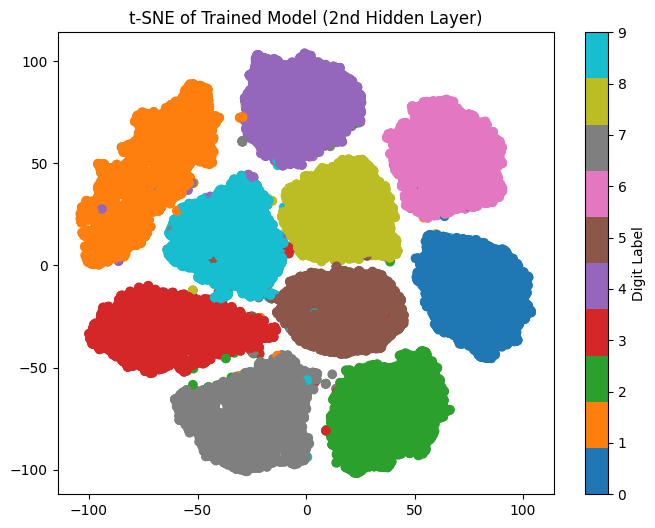

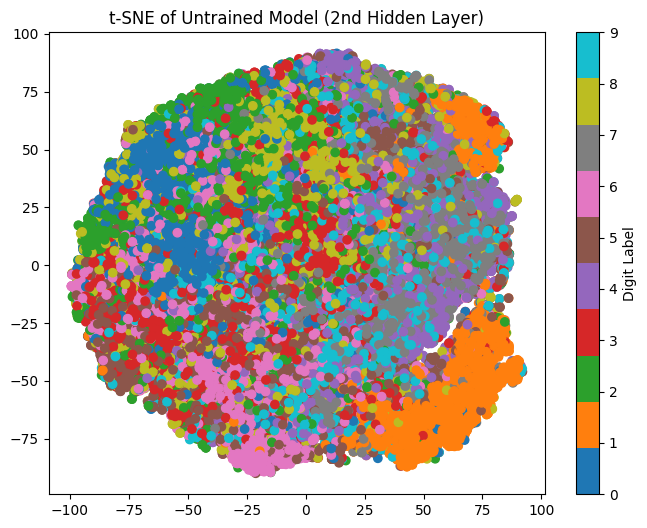

In [68]:
# Perform t-SNE on the hidden layer outputs
def plot_tsne(outputs, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    outputs_2d = tsne.fit_transform(outputs)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(outputs_2d[:, 0], outputs_2d[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter, ticks=range(10), label='Digit Label')
    plt.title(title)
    plt.show()

# 8. Plot t-SNE for both trained and untrained models
plot_tsne(trained_outputs, trained_labels, "t-SNE of Trained Model (2nd Hidden Layer)")
plot_tsne(untrained_outputs, untrained_labels, "t-SNE of Untrained Model (2nd Hidden Layer)")


In [70]:
trained_outputs1, trained_labels1 = extract_hidden_outputs(model, test_loader)
untrained_outputs1, untrained_labels1 = extract_hidden_outputs(mlp_untrained, test_loader)

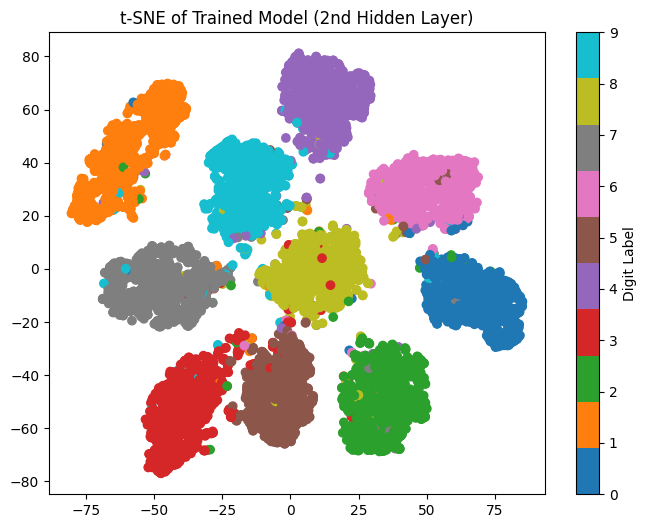

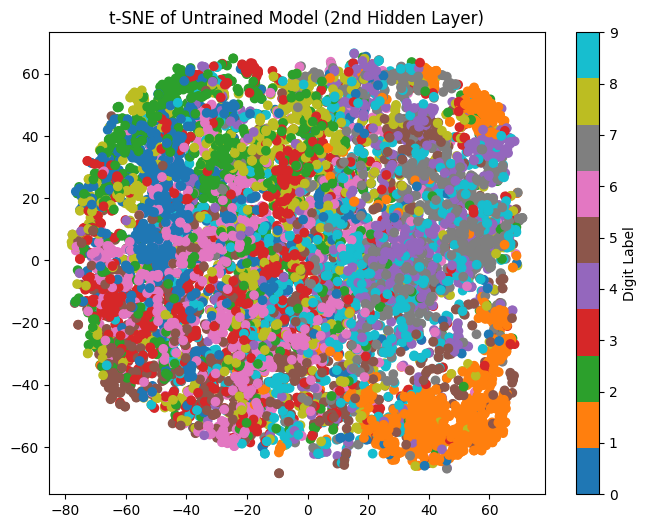

In [71]:
# 8. Plot t-SNE for both trained and untrained models
plot_tsne(trained_outputs1, trained_labels1, "t-SNE of Trained Model (2nd Hidden Layer)")
plot_tsne(untrained_outputs1, untrained_labels1, "t-SNE of Untrained Model (2nd Hidden Layer)")

In [72]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [73]:
# load fashioned 
fashion_mnist_data = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

fashion_loader = DataLoader(fashion_mnist_data, batch_size=64, shuffle=False)

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [77]:
fashion_preds, fashion_labels = evaluate(model, fashion_loader)

In [78]:
# F1-Score for MLP
mlp1_f1 = f1_score(fashion_labels, fashion_preds, average='weighted')

# Confusion Matrix for MLP
mlp_cm_fashion = confusion_matrix(fashion_labels, fashion_preds)

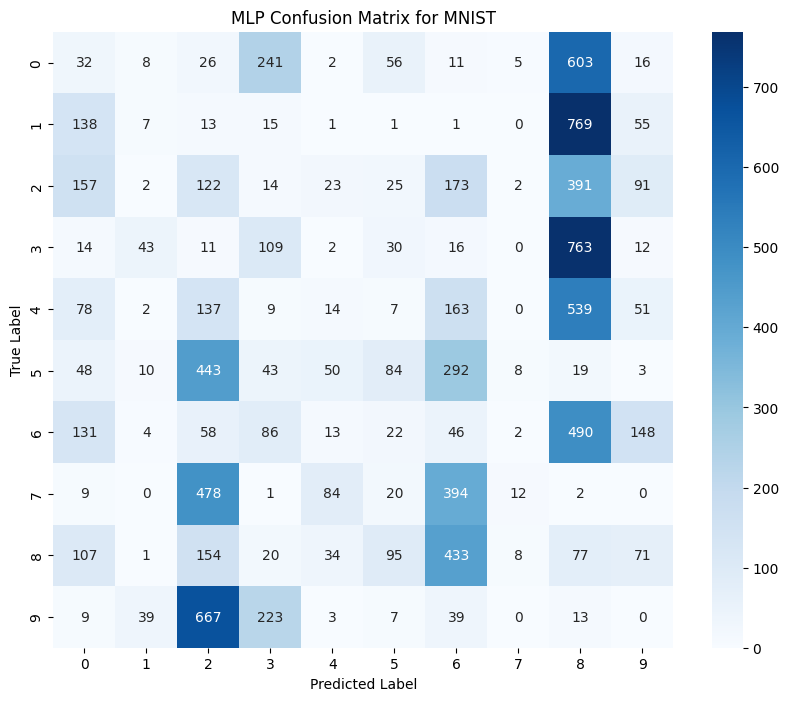

In [79]:
# predict using fashioned mnist
plot_confusion_matrix(mlp_cm_fashion, labels=[str(i) for i in range(10)], title="MLP Confusion Matrix for MNIST")

In [80]:
# tsne using fashioned mnist 

fashion_embeddings, fashion_labels = extract_hidden_outputs(model, fashion_loader)

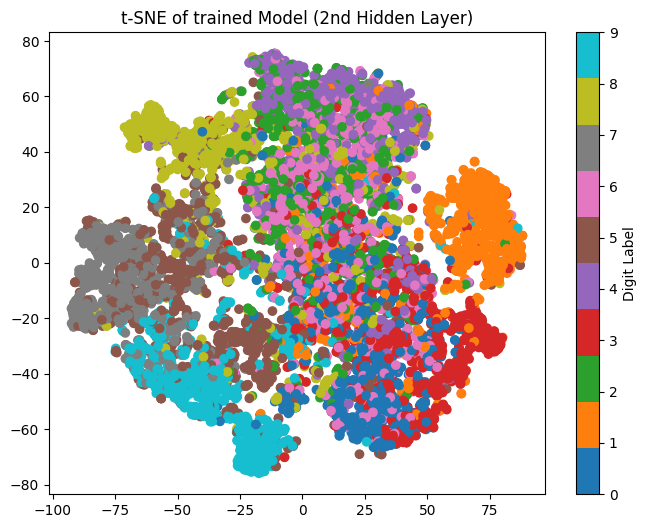

In [82]:
plot_tsne(fashion_embeddings, fashion_labels, "t-SNE of trained Model (2nd Hidden Layer)")